# A step-by-step example running `flowMC`

In this tutorial we will showcase the ability of ``flowMC`` to sample efficiently a 5-dimensional multi-modal distribution. We will go through the typical steps of verification one follows to confirm the quality of the samples at the end of the MCMC run. 

This is a simple example of a 5-dimensional multi-modal distribution:


![Dual Moon](dual_moon.png)


## 1 - The target distribution

The first step is to define the target distribution using `jax`. The target distribution should be a function conforming to the following function signature (using `jaxtyping` convention for type hints):

```python
def target_log_prob_fn(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    ...
    return log_prob
```

`flowMC` will handle batching and compiling the function, so you simply have to provide the version of the function which is evaluated on a specific point in the sample space `X`. `data` represents any additional data that is needed to evaluate the target but not sampled. Note that `data` should remain fixed at run time.

Here below we define our target function:

In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jaxtyping import Float, Array
from typing import Any


def target_dual_moon(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))


n_dims = 5
data = {"data": jnp.arange(n_dims).astype(jnp.float32)}

# Testing evaluation
x = jnp.zeros(n_dims)
print("Testing the value of the target function at x=0: ", target_dual_moon(x, data))

Testing the value of the target function at x=0:  -218.14496


## 2 - Choosing the sampling strategy and resources

In [ ]:
from flowMC.resource_strategy_bundles import RQSpline_MALA_Bundle


n_local_steps = 100
n_global_steps = 10
n_training_loops = 10
n_production_loops = 10
n_epochs = 5
n_chains = 20
rq_spline_hidden_units = [32, 32]
rq_spline_n_bins = 8
rq_spline_n_layers = 4

rng_key = jax.random.PRNGKey(42)


rng_key, subkey = jax.random.split(rng_key)
bundle = RQSpline_MALA_Bundle(
    subkey,
    n_chains,
    n_dims,
    target_dual_moon,
    n_local_steps,
    n_global_steps,
    n_training_loops,
    n_production_loops,
    n_epochs,
    rq_spline_hidden_units=rq_spline_hidden_units,
    rq_spline_n_bins=rq_spline_n_bins,
    rq_spline_n_layers=rq_spline_n_layers,
    learning_rate=5e-3,
    batch_size=10000,
    n_max_examples=10000,
    verbose=False,
)

Resources or strategies not provided. Using resource strategy bundles.


Tuning Phase:   0%|          | 0/10 [00:00<?, ?it/s]

Compiling MALA body


Tuning Phase:   0%|          | 0/10 [00:00<?, ?it/s]

Compiling MALA body


Tuning Phase: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


## 3 - Defining and Running the sampler

In [ ]:
from flowMC.Sampler import Sampler

rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims)) * 1

nf_sampler = Sampler(
    n_dims,
    n_chains,
    rng_key,
    resource_strategy_bundles=bundle,
    # resources=bundle.resources,
    # strategies=[bundle.strategies[1]]
)

nf_sampler.sample(initial_position, data)

## 4 - Inspecting the results

0.0705


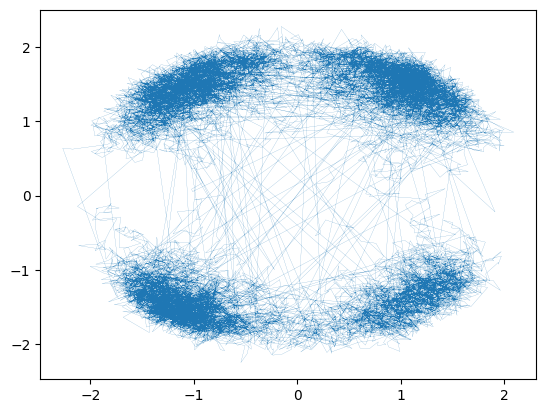

In [ ]:
import matplotlib.pyplot as plt

print(
    np.mean(
        buffer[np.isfinite(nf_sampler.resources["global_accs_production"].buffer)],
        axis=0,
    )
)
test_data = nf_sampler.resources["positions_training"].buffer.reshape(-1, n_dims)
plt.plot(test_data[:, 0], test_data[:, 1], lw=0.1)
# test_data = nf_sampler.resources['global_sampler'].model.sample(jax.random.PRNGKey(42), 10000,)
# plt.scatter(test_data[:, 0], test_data[:, 1], s=0.1)

## 2 - The initial position of walkers 

Here we are going to initialize the walkers by drawing realizations of a standard normal distribution. We now have to set the number of walkers ``n_chains``. 

Note that ``jax`` requires that random seed are explicitly defined at each stochastic step. The package provides a function ``initialize_rng_keys`` to initialize in one go all the seeds necessary for one run. 

In [ ]:
n_chains = 20

rng_key, subkey = jax.random.split(jax.random.PRNGKey(42))
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1

## 3 - The normalizing flow

The ``flowmc`` sampler adaptively trains a normalizing flow (NF) to become an efficient proposal for non-local Metropolis-Hastings steps. The package includes two models of normalizing flows, RealNVPs and RQSpline. Here we go for the simpler class of RQSpline. 

In [ ]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline

n_dim = 5
n_layers = 4
hidden_size = [32, 32]
num_bins = 8
data = jnp.zeros(n_dim)
rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(n_dim, n_layers, hidden_size, num_bins, subkey)

## 4 - Sampler initialization

The ``flowMC`` sampler combines non-local steps driven by the normalizing flow with a local sampler ensuring the MCMC progresses also in the regions that the normalizing flow has not yet learned. 

Here we will employ a MALA sampler, of which we need to choose the stepsize to be passed at run time:

In [ ]:
from flowMC.proposal.MALA import MALA

MALA_Sampler = MALA(target_dual_moon, True, step_size=0.1)

Configuring the full ``flowMC`` sampler requires to specify the schedule of local sampling, global sampling with the NF proposal, and training of the NF.
- ``n_loop_training`` and ``n_loop_production`` fixes the number of cycles of the following operations
- ``n_local_steps`` is the number of iteration of the global sampler per loop
- ``n_global_steps`` is the number of Metropolis-Hastings with the NF proposal steps per loop
- ``num_epochs`` is the number of training epochs per loop

The remaining parameters that can be fixed are the training hyperparameters for the NF model: 
- ``learning_rate``, ``momentum`` and ``batchsize`` for the Adam optimizer
- ``max_samples`` which fixes the maximum number of previous walkers configuration to be used as training data

The ``Sampler`` can be initialized.

In [ ]:
from flowMC.Sampler import Sampler

n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {"data": data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

Everything is ready, we can launch the sampler. The first cycle of sampling-training is the slowest because of the just-in time compilation.

In [ ]:
nf_sampler.sample(initial_position, data={"data": data})

## 5 - Checking the results

First let's look at what happened during the training run during which the global sampler was tuned. 

In [ ]:
out_train = nf_sampler.get_sampler_state(training=True)
print("Logged during tuning:", out_train.keys())

In [ ]:
import corner
import matplotlib.pyplot as plt

In [ ]:
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

Second, let's analyze the production run. We will first visualize the samples and acceptance of the local and global sampler. 

In [ ]:
out_prod = nf_sampler.get_sampler_state()
print("Logged in production:", out_prod.keys())

In [ ]:
chains = np.array(out_prod["chains"])
index = 7  # choosing random chain index to plot results
global_accs = np.array(out_prod["global_accs"])
local_accs = np.array(out_prod["local_accs"])
log_prob_trace = np.array(out_prod["log_prob"][np.array([index, index + 10]), :]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[index, :, 0], chains[index, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[index + 10, :, 0], chains[index + 10, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
# plt.savefig('dual_moon.png')
plt.show(block=False)

Next, we use the `arviz` package to compute $\hat R$ and the Effective Sample Size (ESS) as a function of the length of the chain.

In [ ]:
import arviz as az
from arviz.utils import get_coords, _var_names

## Load data as arviz InferenceData class
idata = az.convert_to_inference_data(chains)
coords = {}
data = get_coords(az.convert_to_dataset(idata, group="posterior"), coords)
var_names = None
filter_vars = None
var_names = _var_names(var_names, data, filter_vars)
n_draws = data.dims["draw"]
n_samples = n_draws * data.dims["chain"]
first_draw = data.draw.values[0]  # int of where where things should start

## Compute where to split the data to diagnostic the convergence
n_split = 7
xdata = np.linspace(n_samples / n_split, n_samples, n_split)
draw_divisions = np.linspace(n_draws // n_split, n_draws, n_split, dtype=int)

rhat_s = np.stack(
    [
        np.array(
            az.rhat(
                data.sel(draw=slice(first_draw + draw_div)),
                var_names=var_names,
                method="rank",
            )["x"]
        )
        for draw_div in draw_divisions
    ]
)

plt.figure()
plt.plot(draw_divisions, rhat_s, "-o", label=labels)
plt.axhline(1, c="k", ls="--")
plt.xlabel("Iteration")
plt.ylabel(r"$\hat{R}$")
plt.legend()